# Практическая работа 5
# Атака с ограниченной памятью (PGD)

## Выполнил студент группы ББМО-02-23
## Макаров Михаил Максимович

#Цель:
 ## Изучить одну из наиболее мощных атак на модели ИИ — атаку Projected Gradient Descent (PGD).
 ## Научиться использовать PGD для создания противоречивых примеров и оценить её влияние на обученные модели.

# Задачи:
 ##1. Загрузить ранее обученную модель на датасете MNIST.
 ##2. Изучить теоретические основы атаки PGD.
 ##3. Реализовать атаку PGD с помощью фреймворка Foolbox.
 ##4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.


### Шаг 1: Загрузка обученной модели и данных MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mmodel.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9738 - loss: 0.0893
Test accuracy on clean images: 0.9767000079154968


###  Шаг 2: Реализация атаки PGD с использованием Foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.6 MB/s eta 0:00:00


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


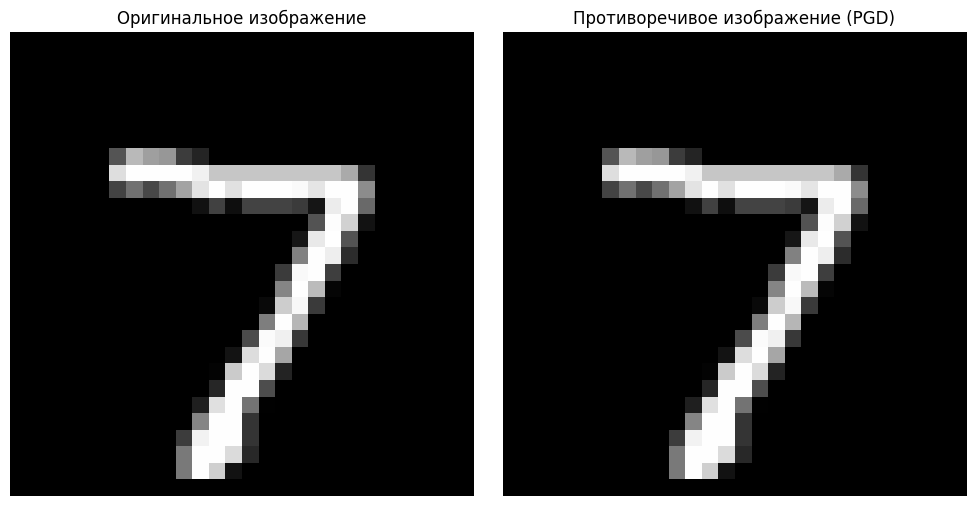

In [2]:
# Установка foolbox (если не установлена)
!pip install foolbox

# Импорт библиотек
import foolbox as fb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  # импорт matplotlib.pyplot

# Подготовка данных
image = tf.convert_to_tensor(test_images[0].reshape(1, 28, 28, 1), dtype=tf.float32)
label = np.argmax(test_labels[0])

# Инициализация Foolbox модели
fmodel = fb.models.TensorFlowModel(model, bounds=(0, 1))

# Создание PGD-атаки
attack = fb.attacks.LinfPGD()

# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, np.array([label]), epsilons=0.00000001)

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(tf.squeeze(image).numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(tf.squeeze(adversarial_image).numpy(), cmap="gray")
plt.axis('off')

plt.tight_layout()
plt.show()

### Шаг 3: Оценка модели на противоречивых примерах

In [12]:

adversarial_images = []

# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0477 - loss: 7.5582
Accuracy on adversarial examples (PGD): 0.06870000064373016


## Вывод

Результаты показывают, что модель демонстрирует высокую точность на чистых изображениях, составляющую 97.63%, что указывает на хорошую обобщающую способность и правильную работу модели на тестовом наборе. Однако после применения атаки PGD точность модели значительно снижается до 6.87%, что является ярким примером того, как атакующие примеры могут ослабить работу модели. Также наблюдается значительное увеличение потерь (loss) до 2.4363, что подтверждает, что модель делает гораздо больше ошибок при классификации атакованных примеров.